In [23]:
import numpy as np
from matplotlib import pyplot as plt

In [24]:
import cv2

In [25]:
image1_jpg = cv2.imread(r'E:\BKP(mag)\Habr\1.jpg', 0)
image2_jpg = cv2.imread(r'E:\BKP(mag)\Habr\2.jpg', 0)

In [26]:
def plot(title_str, image, index):
    plt.subplot(2, 2, index)
    plt.title(title_str)
    plt.imshow(image, 'gray')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

In [27]:
def Method_StereoDepthMap(image1_jpg, image2_jpg):
    # 1: Сопоставлений изображений алгоритмом ORB для обнаружения ключевых точек kp и их описаний des
    orb_object = cv2.ORB_create()
    keypointsList_img1, descriptors_img1 = orb_object.detectAndCompute(image1_jpg, None)
    keypointsList_img2, descriptors_img2 = orb_object.detectAndCompute(image2_jpg, None)
    # Проверка наличия ключевых точек и описаний перед использованием их в алгоритмах
    if len(keypointsList_img1) == 0 or len(keypointsList_img2) == 0 or descriptors_img1 is None or descriptors_img2 is None:
        print("No keypoints or descriptors found.")
        return None
    
    # 2. Для сопоставленных особенностей применяется алгоритм BFMatcher (Brute-Force Matcher) для 
    #нахождения наилучших соответствий.
    matcher_bf_object = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # 3. Полученные соответствия сортируются по расстоянию и сохраняются в переменной matches.
    matches = matcher_bf_object.match(descriptors_img1, descriptors_img2)
    matches = sorted(matches, key=lambda x: x.distance)

    # 4. Координаты соответствующих точек из ключевых точек keypointsList_img1 и keypointsList_img2
    #объединяются в двух матрицах source_points и destination_points.
    source_points = np.vstack([np.array(keypointsList_img1[m.queryIdx].pt) for m in matches])
    destination_points = np.vstack([np.array(keypointsList_img2[m.trainIdx].pt) for m in matches])

    # 5. Используя source_points и destination_points, выполняется нахождение фундаментальной матрицы F и маски
    #с помощью функции cv2.findFundamentalMat, указывающей, какие соответствия считать правильными.
    Fundamental_matrix, mask = cv2.findFundamentalMat(source_points, destination_points)

    # 6. Cтереоректификация с помощью функции cv2.stereoRectifyUncalibrated, которая преобразует
    #изображения в новые изображения с прямыми эпиполярными линиями. Полученные матрицы преобразования
    #сохраняются в переменных left_rectification_matrix и right_rectification_matrix.
    _, left_rectification_matrix , right_rectification_matrix = cv2.stereoRectifyUncalibrated(source_points.reshape(source_points.shape[ 0], 1, 2), destination_points.reshape(destination_points.shape[0], 1, 2), Fundamental_matrix, image1_jpg.shape)
    # Проверка, что рекифицирование удалось:
    if left_rectification_matrix  is None or right_rectification_matrix is None:
        print("Stereo rectification failed.")
        return None
    
    # 7. Получить стереоРектифицированные изображения (матрицы left_rectification_matrix  и right_rectification_matrix применяются к изображениям и получаем
    #прямые эпиполярные изображения)
    rect1 = cv2.warpPerspective(image1_jpg, left_rectification_matrix , (852, 480))
    rect2 = cv2.warpPerspective(image2_jpg, right_rectification_matrix, (852, 480))
    
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    return stereo.compute(rect1, rect2)

In [28]:
def Method_OpticalFlowDepthMap(image1_jpg, image2_jpg):
    vec_optical_flow = cv2.calcOpticalFlowFarneback(image1_jpg, image2_jpg, None, .05, 1, 12, 2, 8, 1.2, 0)
    module_vector_speed, angular_vec_speed = cv2.cartToPolar(vec_optical_flow[..., 0], vec_optical_flow[..., 1])
    return module_vector_speed

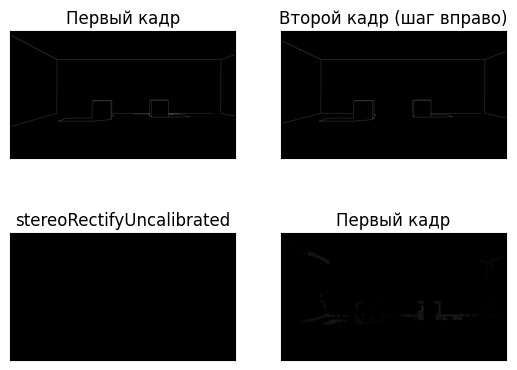

In [29]:
plot(u'Первый кадр', image1_jpg, 1)
plot(u'Второй кадр (шаг вправо)', image2_jpg, 2)
plot(u'stereoRectifyUncalibrated', stereo_depth_map(image1_jpg, img2), 3)
plot(u'Первый кадр', Method_OpticalFlowDepthMap(image1_jpg, image2_jpg), 4)

plt.show()